In [1]:
import sys
import os
sys.path.append("../")

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from VersaQT.data_manip import *

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)  # Width=10, Height=6 (in inches)
corn = yf.download("ZC=F", start="2020-01-01", end="2023-12-31", interval="1d")
corn.columns = corn.columns.get_level_values(0)
corn

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,391.50,392.00,387.25,387.75,103987
2020-01-03,386.50,392.00,385.50,391.50,125931
2020-01-06,384.75,387.75,382.75,386.25,112130
2020-01-07,384.50,385.75,383.50,385.00,93541
2020-01-08,384.25,385.50,382.25,384.00,135523
...,...,...,...,...,...
2023-12-22,473.00,474.00,471.50,472.50,80484
2023-12-26,480.25,481.00,471.50,473.00,114198
2023-12-27,476.50,480.25,474.50,479.75,107950


In [42]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the tickers for corn and soy futures
tickers = ['ZC=F', 'ZS=F']

# Download historical data (e.g., daily close prices)
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')
prices = data['Close']

# Compute daily returns
returns = prices.pct_change().dropna()

# Define the PCA weights function as provided
def pcaWeights(cov, riskDist=None, riskTarget=1.0):
    # Compute eigenvalues and eigenvectors of the covariance matrix
    eVal, eVec = np.linalg.eigh(cov)  # cov must be Hermitian
    # Sort eigenvalues (and corresponding eigenvectors) in descending order
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    
    # If no risk distribution is provided, allocate risk to the last principal component
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1.
    
    # Scale the risk loadings so that the risk matches riskTarget
    loads = riskTarget * (riskDist / eVal) ** 0.5
    wghts = np.dot(eVec, np.reshape(loads, (-1, 1)))
    return wghts.flatten()

# Set up a rolling window to compute time-varying PCA weights
window = 250  # For example, a 60-day rolling window
# Create a DataFrame to store the weights (each column corresponds to an instrument)
pca_weights = pd.DataFrame(index=returns.index, columns=tickers)

# Loop over time indices after the initial window period
for t in range(window, len(returns)):
    # Select the window of returns
    window_returns = returns.iloc[t-window:t]
    # Compute the covariance matrix for this window
    cov_matrix = window_returns.cov().values
    # Compute the PCA weights using the covariance matrix
    weights = pcaWeights(cov_matrix)
    pca_weights.iloc[t] = weights

# pca_weights now holds time-varying weights for corn and soy
print(pca_weights.dropna().head())

[*********************100%***********************]  2 of 2 completed


                 ZC=F        ZS=F
Date                             
2020-12-30   72.32798 -117.998704
2020-12-31  71.819979 -118.429974
2021-01-04  71.676263  -118.52454
2021-01-05  71.686388 -118.535639
2021-01-06  72.112672 -117.362485


In [43]:
pca_weights.dropna()

,ZC=F,ZS=F
Date,,
2020-12-30,72.32798,-117.998704
2020-12-31,71.819979,-118.429974
2021-01-04,71.676263,-118.52454
2021-01-05,71.686388,-118.535639
2021-01-06,72.112672,-117.362485
...,...,...
2023-12-22,28.287881,-84.323128
2023-12-26,28.241466,-84.365935
2023-12-27,28.366498,-84.292315


# ETF Trick and PCA Weights

$$
    h_{i, t-1} = 
    % \begin{cases}
        \frac{\omega_{i, t-1}K_{t-1}}{o_{i, t}, \phi_{i, t-1}\sum_{i=1}^I|\omega_{i, t-1}|}
    % \end{cases}
$$

In [44]:
data

Price        Close             High              Low             Open  \
Ticker        ZC=F     ZS=F    ZC=F     ZS=F    ZC=F     ZS=F    ZC=F   
Date                                                                    
2020-01-02  391.50   944.25  392.00   949.00  387.25   941.75  387.75   
2020-01-03  386.50   930.50  392.00   945.25  385.50   926.75  391.50   
2020-01-06  384.75   932.75  387.75   936.25  382.75   929.00  386.25   
2020-01-07  384.50   935.00  385.75   935.00  383.50   928.75  385.00   
2020-01-08  384.25   938.25  385.50   940.00  382.25   935.75  384.00   
...            ...      ...     ...      ...     ...      ...     ...   
2023-12-22  473.00  1299.75  474.00  1308.00  471.50  1294.00  472.50   
2023-12-26  480.25  1313.25  481.00  1314.50  471.50  1296.00  473.00   
2023-12-27  476.50  1316.75  480.25  1318.75  474.50  1303.00  479.75   
2023-12-28  474.25  1305.25  478.75  1324.25  474.00  1303.00  476.00   
2023-12-29  471.25  1293.50  475.00  1311.75  470.50  1292.25  473.75   

Price                Volume         
Ticker         ZS=F    ZC=F   ZS=F  
Date                                
2020-01-02   943.25  103987   2217  
2020-01-03   944.50  125931   2272  
2020-01-06   929.25  112130   1524  
2020-01-07   933.50   93541    866  
2020-01-08   936.25  135523    576  
...             ...     ...    ...  
2023-12-22  1296.75   80484  52365  
2023-12-26  1299.75  114198  34317  
2023-12-27  1310.50  107950  37407  
2023-12-28  1315.75   99398  23869  
2023-12-29  1304.75  109649   6682  

[1006 rows x 10 columns]

In [ ]:
weights
open = corn.Open
close = corn.Close
value = corn.Close
volume = corn.Volume
dividend = np.array([0 for _ in corn.Close])

In [ ]:
pca_weights.dropna()

,ZC=F,ZS=F
Date,,
2020-03-31,52.216195,-114.926535
2020-04-01,51.23401,-116.219823
2020-04-02,54.091892,-110.341465
2020-04-03,54.085647,-110.371499
2020-04-06,54.090254,-110.595072
...,...,...
2023-12-22,41.54734,-86.133575
2023-12-26,42.448375,-86.071352
2023-12-27,40.351215,-87.511122


In [ ]:
pca_weights.dropna()/(open.shift)

,ZC=F,ZS=F
Date,,
2020-03-31,104.432391,-229.853069
2020-04-01,102.468021,-232.439647
2020-04-02,108.183785,-220.68293
2020-04-03,108.171295,-220.742998
2020-04-06,108.180507,-221.190144
...,...,...
2023-12-22,83.094681,-172.26715
2023-12-26,84.896749,-172.142704
2023-12-27,80.70243,-175.022244


In [ ]:
h = weights

In [5]:
# def ETFTrick(weights, open, close, value, volume, dividend):

def ETFTrick(weights, open_prices, close_prices, value, volume, dividend):
    """
    Implements the ETF Trick, converting a basket of securities into a single synthetic ETF-like series.
    
    Parameters:
    - weights: DataFrame (T x I) of instrument weights over time
    - open_prices: DataFrame (T x I) of instrument open prices
    - close_prices: DataFrame (T x I) of instrument close prices
    - value: DataFrame (T x I) representing the USD value per contract
    - volume: DataFrame (T x I) of traded volume
    - dividend: DataFrame (T x I) of dividends or other cashflows

    Returns:
    - K: Series (T) representing the value of $1 invested in the synthetic ETF
    """
    
    # Initialize investment value with $1
    K = pd.Series(index=weights.index, dtype=float)
    K.iloc[0] = 1  # Initial investment
    
    # Compute holdings: h_i,t = (weights / sum(|weights|)) * K
    holdings = weights.div(weights.abs().sum(axis=1), axis=0) * K.shift(1)
    
    # Compute change in market value
    delta_price = close_prices - open_prices.shift(1)
    
    # Compute PnL contribution
    pnl = (holdings.shift(1) * value * (delta_price + dividend)).sum(axis=1)
    
    # Compute new K values (reinvesting PnL)
    K.iloc[1:] = K.iloc[0] + pnl.iloc[1:].cumsum()
    
    return K



def pcaWeights(cov,riskDist=None,riskTarget=1.):
    # Following the riskAlloc distribution, match riskTarget
    eVal,eVec=np.linalg.eigh(cov) # must be Hermitian
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    if riskDist is None:
        riskDist=np.zeros(cov.shape[0])
        riskDist[-1]=1.
    loads=riskTarget*(riskDist/eVal)**.5
    wghts=np.dot(eVec,np.reshape(loads,(-1,1)))
    
    #ctr=(loads/riskTarget)**2*eVal # verify riskDist
    return wghts

In [12]:
ETFTrick(pd.DataFrame(pcaWeights(corn.cov())), corn.Open, corn.Close, corn.Close, corn.Volume, np.array([0 for _ in corn.Close]))

C:\Users\guilherme\AppData\Local\Temp\ipykernel_7800\2453557548.py:30: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  pnl = (holdings.shift(1) * value * (delta_price + dividend)).sum(axis=1)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

# Single Futures Roll

In [62]:
def rollGaps(series, rollDates, dictio={'Open': 'Open', 'Close': 'Close'}, matchEnd=True):
    """
    Computes cumulative roll gaps and optionally shifts them to match the series start or end.

    :param series: DataFrame with futures prices.
    :param dictio: Mapping of column names for contract ID, open, and close prices.
    :param matchEnd: If True, aligns the series to match the raw price at the end.
    :return: Series of cumulative roll gaps.
    """
    
    # Initialize gap series
    gaps = series[dictio['Close']] * 0
    
    # Compute gaps as difference between new contract open and previous contract close
    iloc = list(series.index)
    iloc = [iloc.index(i) - 1 for i in rollDates]  # Get index of last price before roll
    gaps.loc[rollDates[1:]] = series[dictio['Open']].loc[rollDates[1:]] - series[dictio['Close']].iloc[iloc[1:]].values
    
    # Cumulative sum of roll gaps
    gaps = gaps.cumsum()
    
    # Adjust to match the series end if needed
    if matchEnd:
        gaps -= gaps.iloc[-1]  # Shift back so the last value aligns
    
    return gaps

def getRolledSeries(series_in):
    """
    Reads raw futures data, applies roll gap correction, and returns a continuous price series.
    
    :param pathIn: Path to the HDF5 file.
    :param key: Key for the HDF5 dataset.
    :return: DataFrame with adjusted price series.
    """

    series = series_in.copy()
    
    # Compute roll gaps
    dates = series.index.values
    gaps = rollGaps(series, dates)
    
    # Apply roll adjustments to close price and VWAP
    for fld in ['Close', 'Volume']:
        series[fld] -= gaps
    
    return series


# Second version to get rolled series, so that it won't become negative
# Implement this as a parameter in the original method
gaps=rollGaps(corn.copy(),corn.copy().index.values)
rolled=corn.copy(deep=True)
for fld in ['Open','Close']:
    rolled[fld]-=gaps
rolled['Returns']=rolled['Close'].diff()/corn['Close'].shift(1)
rolled['rPrices']=(1+rolled['Returns']).cumprod()

In [63]:
rolled_corn = getRolledSeries(corn)

(-10.0, 850.0)

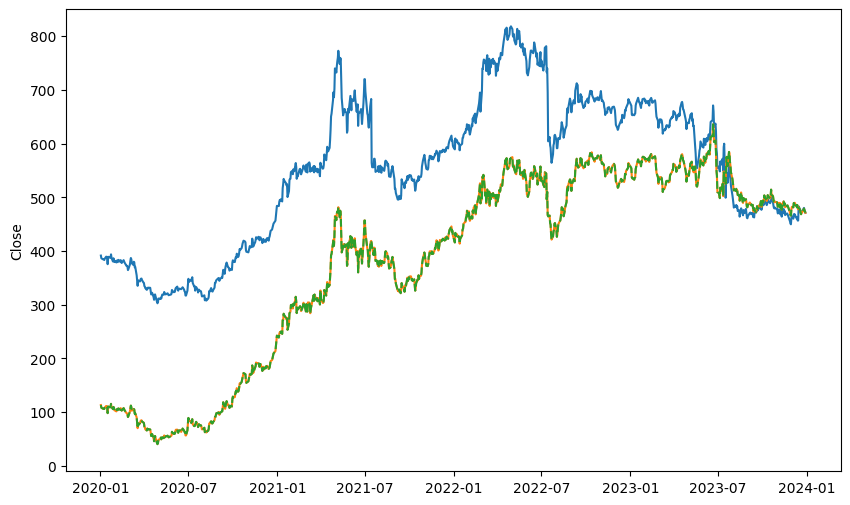

In [71]:
sns.lineplot(corn, y="Close", x=corn.index.values)
sns.lineplot(rolled_corn, y="Close", x=rolled_corn.index.values)
sns.lineplot(rolled, y="Close", x=rolled.index.values, linestyle="--")
plt.ylim(-10, 850)

# Sampling Features

In [104]:
def CUSUM_filter(gRaw,h):
    tEvents,sPos,sNeg=[],0,0
    diff=gRaw.diff()

    for i in diff.index[1:]:
      sPos,sNeg=max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])

      if sNeg<-h:
        sNeg=0;tEvents.append(i)
      elif sPos>h:
        sPos=0;tEvents.append(i)

    return pd.DatetimeIndex(tEvents)

In [106]:
indexes = CUSUM_filter(corn.Close, 101)
indexes

DatetimeIndex(['2020-10-19', '2021-01-12', '2021-04-20', '2021-04-30',
               '2021-05-17', '2021-07-15', '2021-12-21', '2022-02-24',
               '2022-03-11', '2022-07-14', '2022-07-20', '2022-08-24',
               '2023-05-15', '2023-06-21', '2023-06-30', '2023-08-01'],
              dtype='datetime64[ns]', freq=None)

<Axes: ylabel='Close'>

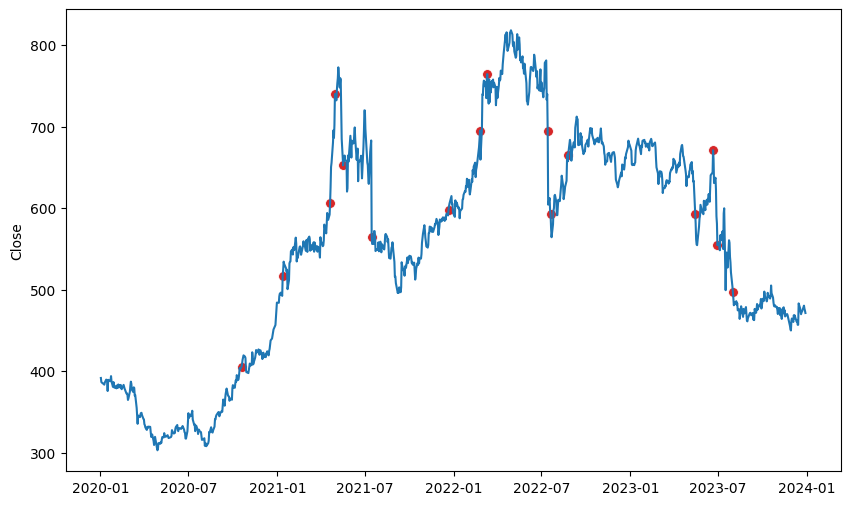

In [115]:
sns.lineplot(corn, y="Close", x=corn.index.values)
sns.scatterplot(corn.loc[indexes], y="Close", x=corn.loc[indexes].index.values, s=50, c="tab:red")
